<a href="https://colab.research.google.com/github/pachterlab/CBP_2021/blob/main/notebooks/VMHNeurons/kimetal_tenx_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import os


from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
	url = 'https://api.datacite.org/dois/'+doi+'/media'
	r = requests.get(url).json()
	netcdf_url = r['data'][0]['attributes']['url']
	r = requests.get(netcdf_url,stream=True)
	#Set file name
	fname = doi.split('/')[-1]+ext
	#Download file with progress bar
	if r.status_code == 403:
		print("File Unavailable")
	if 'content-length' not in r.headers:
		print("Did not get file")
	else:
		with open(fname, 'wb') as f:
			total_length = int(r.headers.get('content-length'))
			pbar = tnrange(int(total_length/1024), unit="B")
			for chunk in r.iter_content(chunk_size=1024):
				if chunk:
					pbar.update()
					f.write(chunk)
		return fname


#10x VMH data
#metadata.csv
download_file('10.22002/D1.2065','.gz')

#tenx.mtx (log counts)
download_file('10.22002/D1.2072','.gz')

#10X raw Count Matrix
download_file('10.22002/D1.2073','.gz')

#var.csv
download_file('10.22002/D1.2066','.gz')



os.system("gunzip *.gz")

os.system("mv D1.2065 metadata.csv")
os.system("mv D1.2072 tenx.mtx")
os.system("mv D1.2073 tenxCount.mtx")
os.system("mv D1.2066 tenx_var.csv")

In [ ]:
!git clone https://github.com/pachterlab/CBP_2021.git

Cloning into 'spacetime'...
remote: Enumerating objects: 1385, done.
remote: Counting objects: 100% (669/669), done.
remote: Compressing objects: 100% (573/573), done.
remote: Total 1385 (delta 484), reused 168 (delta 95), pack-reused 716
Receiving objects: 100% (1385/1385), 146.30 MiB | 11.82 MiB/s, done.
Resolving deltas: 100% (930/930), done.


In [ ]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy==1.6.0
!pip3 install --quiet umap-learn
!pip3 install --quiet scvi-tools

     |████████████████████████████████| 133kB 8.2MB/s 
     |████████████████████████████████| 7.7MB 2.0MB/s 
     |████████████████████████████████| 81kB 11.4MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
     |████████████████████████████████| 1.1MB 31.6MB/s 
     |████████████████████████████████| 215kB 8.1MB/s 
     |████████████████████████████████| 245kB 48.2MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 215kB 49.1MB/s 
     |████████████████████████████████| 686kB 52.6MB/s 
     |████████████████████████████████| 819kB 49.3MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 10.6MB 51.4MB/s 
     |████████████████████████████████| 645kB 46.1MB/s 
     |████████████████████████████████| 829kB 36.6MB/s 
     |████████████████████████████████| 122kB 52.6MB/s 
     |████████████████████████████████| 235kB 49.9MB/s 
     |████████████████████████████████| 1.3MB 46.4MB/s 


In [ ]:
%cd /content/CBP_2021/scripts

/content/spacetime/nnNCApy


## **Install Packages**

In [ ]:
import anndata 
import pandas as pd
import numpy as np
from MCML import MCML #Now has continuous label addition

import random
import scvi
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
sns.set_style('white')

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


## **Import Data**

In [ ]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '../..'

pcs = 50
n_latent = 50

In [ ]:
count_mat = sio.mmread(data_path+'/tenx.mtx')
count_mat.shape

(41580, 1999)

In [ ]:
rawcount_mat = sio.mmread(data_path+'/tenxCount.mtx')
rawcount_mat.shape

(41580, 1999)

In [ ]:
#Center and scale log-normalized data
scaled_mat = scale(count_mat)

In [ ]:
meta = pd.read_csv(data_path+'/metadata.csv',index_col = 0)
meta.head()

,sample_name,cell_barcode,cluster_color,cluster,cluster_id,cell_types,sex_label,batch_indices,cell_counts,n_genes,percent_mito,pass_count_filter,pass_mito_filter
0,10x_VMH_Female_Control_1,4_AAACCTGAGCGCCTCA,#9162FF,Nr5a1_4,24.0,undefined,F,0,1427.0,926,13.594954,True,False
1,10x_VMH_Female_Control_1,4_AAACCTGCACAGTCGC,#96FF2E,Tsix_Esr1_1,3.0,undefined,F,0,4508.0,2310,9.272405,True,False
2,10x_VMH_Female_Control_1,4_AAACCTGCAGATTGCT,#66ABC2,Dlk1_3,16.0,undefined,F,0,3447.0,1995,5.483029,True,False
3,10x_VMH_Female_Control_1,4_AAACCTGCATACTCTT,#96FF2E,Tsix_Esr1_1,3.0,undefined,F,0,7004.0,3286,4.483152,True,True
4,10x_VMH_Female_Control_1,4_AAACCTGGTCCGTTAA,#24EFCD,Scgn,20.0,undefined,F,0,2490.0,1492,9.277108,True,False


In [ ]:
clusters = np.unique(meta['cluster'].values)
map_dict = {}
for i, c in enumerate(clusters):
  map_dict[c] = i
new_labs = [map_dict[c] for c in meta['cluster'].values]

In [ ]:
adata = anndata.AnnData(count_mat, obs = meta)
adata.X = np.nan_to_num(adata.X)

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
adata2 = anndata.AnnData(rawcount_mat, obs = meta)
adata2.X = np.nan_to_num(adata2.X)

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
def knn_infer(embd_space, labeled_idx, labeled_lab, unlabeled_idx,n_neighbors=50):
	"""
	Predicts the labels of unlabeled data in the embedded space with KNN.
	Parameters
	----------
	embd_space : ndarray (n_samples, embedding_dim)
		Each sample is described by the features in the embedded space.
		Contains all samples, both labeled and unlabeled.
	labeled_idx : list
		Indices of the labeled samples (used for training the classifier).
	labeled_lab : ndarray (n_labeled_samples)
		Labels of the labeled samples.
	unlabeled_idx : list
		Indices of the unlabeled samples.
	Returns
	-------
	pred_lab : ndarray (n_unlabeled_samples)
		Inferred labels of the unlabeled samples.
	"""

	# obtain labeled data and unlabled data from indices
	labeled_samp = embd_space[labeled_idx, :]
	unlabeled_samp = embd_space[unlabeled_idx, :]

	from sklearn.neighbors import KNeighborsClassifier

	knn = KNeighborsClassifier(n_neighbors=n_neighbors)
	knn.fit(labeled_samp, labeled_lab)

	pred_lab = knn.predict(unlabeled_samp)
	return pred_lab


In [ ]:
# LDVAE accuracy scores
scvi.data.setup_anndata(adata2, labels_key='cluster_id')
acc_score = []
acc_score2 = []
for i in range(3): #3
  vae = scvi.model.LinearSCVI(adata2)
  vae.train() #train_size = 0.7
  latent_ldvae = vae.get_latent_representation()
  lab_idx = vae.train_indices
  unlabeled_idx = []
  for i in range(len(adata2)):
    if i not in lab_idx:
      unlabeled_idx.append(i)
  preds = knn_infer(np.array(latent_ldvae), list(lab_idx), adata2.obs.cluster_id.values[lab_idx], unlabeled_idx)
  acc = accuracy_score(adata2.obs.cluster_id.values[unlabeled_idx], preds)
  acc_score.append(acc)

  preds2 = knn_infer(np.array(latent_ldvae), list(lab_idx), adata2.obs.sex_label.values[lab_idx], unlabeled_idx)
  acc2 = accuracy_score(adata2.obs.sex_label.values[unlabeled_idx], preds2)
  acc_score2.append(acc2)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["cluster_id"]                                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 41580 cells, 1999 vars, 1 batches,
         30 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 192/192: 100%|██████████| 192/192 [06:38<00:00,  2.08s/it, loss=669, v_num=1]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 192/192: 100%|██████████| 192/192 [06:43<00:00,  2.10s/it, loss=678, v_num=1]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 192/192: 100%|██████████| 192/192 [06:44<00:00,  2.11s/it, loss=682, v_num=1]


In [ ]:
acc_score

[0.6831810165143498, 0.6818983485650152, 0.6817380150713485]

In [ ]:
# SCANVI accuracy scores
scvi.data.setup_anndata(adata2, labels_key='cluster_id')
acc_score_scanvi = []
acc_score_scanvi2 = []
for i in range(3):
  vae = scvi.model.SCANVI(adata2, np.nan)
  vae.train(train_size = 0.7)
  latent_scanvi = vae.get_latent_representation()
  lab_idx = vae.train_indices
  unlabeled_idx = []
  for i in range(len(adata2)):
    if i not in lab_idx:
      unlabeled_idx.append(i)
  preds = knn_infer(np.array(latent_scanvi), list(lab_idx), adata2.obs.cluster_id.values[lab_idx], unlabeled_idx)
  acc = accuracy_score(adata2.obs.cluster_id.values[unlabeled_idx], preds)
  acc_score_scanvi.append(acc)

  preds2 = knn_infer(np.array(latent_scanvi), list(lab_idx), adata2.obs.sex_label.values[lab_idx], unlabeled_idx)
  acc2 = accuracy_score(adata2.obs.sex_label.values[unlabeled_idx], preds2)
  acc_score_scanvi2.append(acc2)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["cluster_id"]                                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 41580 cells, 1999 vars, 1 batches,
         30 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          
INFO     Training for 192 epochs.                                                            


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 192/192: 100%|██████████| 192/192 [13:40<00:00,  4.27s/it, loss=791, v_num=1]
INFO     Training for 192 epochs.                                                            


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 192/192: 100%|██████████| 192/192 [13:39<00:00,  4.27s/it, loss=789, v_num=1]
INFO     Training for 192 epochs.                                                            


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 192/192: 100%|██████████| 192/192 [13:33<00:00,  4.24s/it, loss=792, v_num=1]


In [ ]:
print(acc_score_scanvi)
print(acc_score_scanvi2)

[0.7808241141574475, 0.783629950296617, 0.7790604457271124]
[0.9048420715087382, 0.8896103896103896, 0.9135000801667469]


In [ ]:
lab1 = list(meta.cluster)
lab2 = list(meta.sex_label)
# lab3 = list(meta.medical_cond_label)


allLabs = np.array([lab1])
allLabs2 = np.array([lab1,lab2])

nanLabs = np.array([[np.nan]*len(lab1)])

#Shuffled labels for over-fitting check
shuff_lab1 = random.sample(lab1, len(lab1))  
shuff_lab2 = random.sample(lab2, len(lab2))  
shuff_allLabs = np.array([shuff_lab1,shuff_lab2])

clus_colors = list(pd.unique(meta.cluster_color))

sex_colors = ['#abacb7','#F8C471']

Check train/test overfitting (with cell type labels)

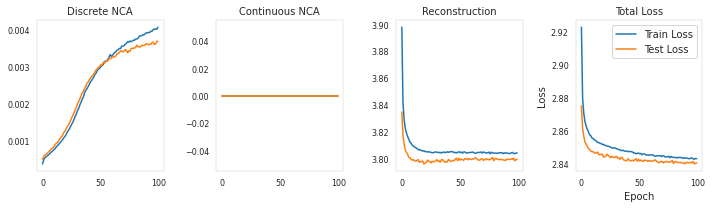

In [ ]:
# nca.fit(scaled_mat,labels,fracNCA = 0.25, silent = True,ret_loss = True) Parameters used for prediction
nca = MCML(n_latent = n_latent, epochs = 100)

lossesTrain, lossesTest = nca.trainTest(scaled_mat,np.array([lab1]), fracNCA = 0.25, silent = True)
nca.plotLosses(figsize=(10,3),fname='tenxTrainTest.pdf',axisFontSize=10,tickFontSize=8)

In [ ]:
# Reconstruction loss only
acc_scoreR = []
acc_scoreR2 = []

for i in range(3):
  ncaR = MCML(n_latent = n_latent, epochs = 100)
  labels = np.array([lab1])
  train_inds = np.random.choice(len(scaled_mat), size = int(0.7*len(scaled_mat)),replace=False)
  unlab_inds = [i for i in range(len(adata)) if i not in train_inds]
  labels[:, unlab_inds] = np.nan
  
  lossesR, latentR = ncaR.fit(scaled_mat,nanLabs,fracNCA = 0, silent = True,ret_loss = True)
  toc = time.perf_counter()
  unlabeled_idx = []
  for i in range(len(adata)):
      if i not in train_inds:
          unlabeled_idx.append(i)
  preds = knn_infer(latentR, train_inds, adata.obs.cluster.values[train_inds], unlabeled_idx)
  acc = accuracy_score(adata.obs.cluster.values[unlabeled_idx], preds)
  acc_scoreR.append(acc)

  preds2 = knn_infer(latentR, train_inds, adata.obs.sex_label.values[train_inds], unlabeled_idx)
  acc2 = accuracy_score(adata.obs.sex_label.values[unlabeled_idx], preds2)
  acc_scoreR2.append(acc2)
  # print(f"nnNCA fit in {toc - tic:0.4f} seconds")

In [ ]:
print(acc_scoreR)
print(acc_scoreR2)


[0.8298997995991984, 0.8358316633266533, 0.8317434869739478]
[0.9102204408817636, 0.9123847695390782, 0.9093386773547094]


PCA 50D

In [ ]:
# Reconstruction loss only
acc_scorePCA = []
acc_scorePCA2 = []

for i in range(3):

  tsvd = TruncatedSVD(n_components=pcs)
  x_pca = tsvd.fit_transform(scaled_mat)
  
  labels = np.array([lab1])
  train_inds = np.random.choice(len(scaled_mat), size = int(0.7*len(scaled_mat)),replace=False)
  unlab_inds = [i for i in range(len(adata)) if i not in train_inds]
  labels[:, unlab_inds] = np.nan
  
  unlabeled_idx = []
  for i in range(len(adata)):
      if i not in train_inds:
          unlabeled_idx.append(i)

  preds = knn_infer(x_pca, train_inds, adata.obs.cluster.values[train_inds], unlabeled_idx)
  acc = accuracy_score(adata.obs.cluster.values[unlabeled_idx], preds)
  acc_scorePCA.append(acc)

  preds2 = knn_infer(x_pca, train_inds, adata.obs.sex_label.values[train_inds], unlabeled_idx)
  acc2 = accuracy_score(adata.obs.sex_label.values[unlabeled_idx], preds2)
  acc_scorePCA2.append(acc2)
  # print(f"nnNCA fit in {toc - tic:0.4f} seconds")

In [ ]:
print(acc_scorePCA)
print(acc_scorePCA2)

[0.816192384769539, 0.8143486973947895, 0.8129058116232465]
[0.9044488977955912, 0.9079759519038076, 0.9068537074148296]


NCA Below

In [ ]:
# NCA loss only
acc_scoreNCA = []
acc_scoreNCA2 = []
acc_scoreNCA3 = []

for i in range(1): #3
  nca = MCML(n_latent = n_latent, epochs = 100)
  ncaR2 = MCML(n_latent = n_latent, epochs = 100)

  labels = np.array([lab1]).copy()
  train_inds = np.random.choice(len(scaled_mat), size = int(0.7*len(scaled_mat)),replace=False) #0.7
  unlab_inds = [i for i in range(len(adata)) if i not in train_inds]
  labels[:, unlab_inds] = np.nan

  #2 labels
  labels2 = allLabs2.copy()
  labels2[:, unlab_inds] = np.nan

  losses, latent = nca.fit(scaled_mat,labels,fracNCA = 1, silent = True,ret_loss = True)

  losses2, latent2 = ncaR2.fit(scaled_mat,labels2,fracNCA = 1, silent = True,ret_loss = True)

  toc = time.perf_counter()
  unlabeled_idx = []
  for i in range(len(adata)):
      if i not in train_inds:
          unlabeled_idx.append(i)
  preds = knn_infer(latent, train_inds, adata.obs.cluster.values[train_inds], unlabeled_idx)
  acc = accuracy_score(adata.obs.cluster.values[unlabeled_idx], preds)
  acc_scoreNCA.append(acc)

  preds2 = knn_infer(latent2, train_inds, adata.obs.cluster.values[train_inds], unlabeled_idx)
  acc2 = accuracy_score(adata.obs.cluster.values[unlabeled_idx], preds2)
  acc_scoreNCA2.append(acc2)

  preds2 = knn_infer(latent2, train_inds, adata.obs.sex_label.values[train_inds], unlabeled_idx)
  acc2 = accuracy_score(adata.obs.sex_label.values[unlabeled_idx], preds2)
  acc_scoreNCA3.append(acc2)

  # print(f"nnNCA fit in {toc - tic:0.4f} seconds")

In [ ]:
print(acc_scoreNCA)
print(acc_scoreNCA2)
print(acc_scoreNCA3)

[0.7521442885771543]
[0.7487775551102205]
[0.872064128256513]


In [ ]:
# fracNCA = 0.3
acc_scoreBoth = []
acc_scoreBoth2 = []
acc_scoreBoth3 = []

for i in range(3): #3
  nca = MCML(n_latent = n_latent, epochs = 100)
  ncaR2 = MCML(n_latent = n_latent, epochs = 100)

  labels = np.array([lab1]).copy()
  train_inds = np.random.choice(len(scaled_mat), size = int(0.7*len(scaled_mat)),replace=False)
  unlab_inds = [i for i in range(len(adata)) if i not in train_inds]
  labels[:, unlab_inds] = np.nan

  #2 labels
  labels2 = allLabs2.copy()
  labels2[:, unlab_inds] = np.nan

  losses, latent = nca.fit(scaled_mat,labels,fracNCA = 0.25, silent = True,ret_loss = True)
  losses2, latent2 = ncaR2.fit(scaled_mat,labels2,fracNCA = 0.25, silent = True,ret_loss = True)


  toc = time.perf_counter()
  unlabeled_idx = []
  for i in range(len(adata)):
      if i not in train_inds:
          unlabeled_idx.append(i)
  preds = knn_infer(latent, train_inds, adata.obs.cluster.values[train_inds], unlabeled_idx)
  acc = accuracy_score(adata.obs.cluster.values[unlabeled_idx], preds)
  acc_scoreBoth.append(acc)

  preds2 = knn_infer(latent2, train_inds, adata.obs.cluster.values[train_inds], unlabeled_idx)
  acc2 = accuracy_score(adata.obs.cluster.values[unlabeled_idx], preds2)
  acc_scoreBoth2.append(acc2)

  preds2 = knn_infer(latent2, train_inds, adata.obs.sex_label.values[train_inds], unlabeled_idx)
  acc2 = accuracy_score(adata.obs.sex_label.values[unlabeled_idx], preds2)
  acc_scoreBoth3.append(acc2)

  # # print(f"nnNCA fit in {toc - tic:0.4f} seconds")

In [ ]:
print(acc_scoreBoth)
print(acc_scoreBoth2)
print(acc_scoreBoth3)

[0.836312625250501, 0.8432865731462926, 0.8446492985971944]
[0.8392785571142285, 0.8459318637274549, 0.8428857715430862]
[0.919438877755511, 0.919438877755511, 0.9228857715430862]


In [ ]:
# # get confidence intervals
# ldvae_int = st.t.interval(0.95, df = 2, loc = np.mean(acc_score), scale = np.std(acc_score))
# scanvi_int = st.t.interval(0.95, df=2, loc = np.mean(acc_score_scanvi), scale = np.std(acc_score_scanvi))
# recon_int = st.t.interval(0.95, df = 2, loc = np.mean(acc_scoreR), scale = np.std(acc_scoreR))
# nca_int = st.t.interval(0.95, df=2, loc = np.mean(acc_scoreNCA), scale = np.std(acc_scoreNCA))
# both_int = st.t.interval(0.95, df=2, loc = np.mean(acc_scoreBoth), scale = np.std(acc_scoreBoth))

In [ ]:
# # plot
# fig, ax = plt.subplots()
# ax.errorbar(0, np.mean(acc_score), 
#              yerr = [ldvae_int[1] - np.mean(acc_score)], fmt = 'o', label = 'LDVAE')
# ax.errorbar(1,  np.mean(acc_score_scanvi), 
#              yerr = scanvi_int[1] - np.mean(acc_score_scanvi), fmt = 'o', label = 'SCANVI')
# ax.errorbar(2, np.mean(acc_scoreR), 
#              yerr = [recon_int[1] - np.mean(acc_scoreR)], fmt = 'o', label = 'reconstruction')
# ax.errorbar(3,  np.mean(acc_score_scanvi), 
#              yerr = nca_int[1] - np.mean(acc_scoreNCA), fmt = 'o', label = 'NCA')
# ax.errorbar(4,  np.mean(acc_score_scanvi), 
#              yerr = both_int[1] - np.mean(acc_scoreBoth), fmt = 'o', label = '0.5 fracNCA')
# plt.ylabel("accuracy score")
# plt.legend(loc = "upper right", bbox_to_anchor = (1.4, 1.0))
# plt.title("Kim et al 10X Accuracy Comparisons")
# ax.get_xaxis().set_visible(False)
# plt.savefig("tenx_comparisons")
# plt.show()

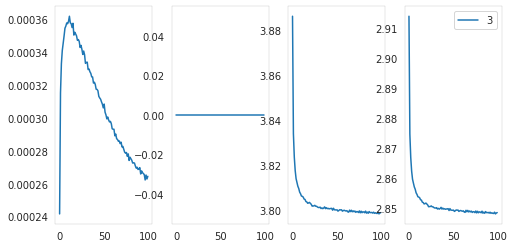

In [ ]:
fig, axs = plt.subplots(1, losses.shape[1],figsize=(8,4))
for i in range(losses.shape[1]):
  axs[i].plot(losses[:,i],label=str(i))
  
plt.legend()
plt.show()

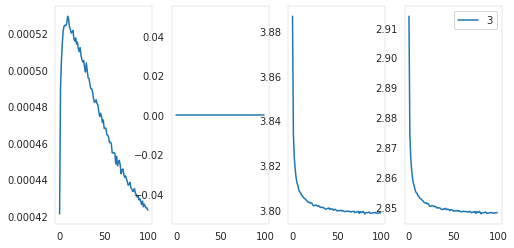

In [ ]:
fig, axs = plt.subplots(1, losses2.shape[1],figsize=(8,4))
for i in range(losses2.shape[1]):
  axs[i].plot(losses2[:,i],label=str(i))
  
plt.legend()
plt.show()

### **Save Analysis Output**

In [ ]:
vals = pd.DataFrame()

vals['Accuracy'] = acc_score + acc_score_scanvi + acc_scoreR + acc_scoreNCA + acc_scoreBoth + acc_score2 + acc_score_scanvi2 + acc_scoreR2 + acc_scoreNCA3 + acc_scoreBoth3 + acc_scoreNCA2 + acc_scoreBoth2 +
acc_scorePCA +acc_scorePCA2  #+ netAE_score + netAE_score2

In [ ]:
vals['Embed'] = ['LDVAE']*3 + ['SCANVI']*3 + ['Recon MCML']*3 + ['NCA 100% MCML']*1 + ['NCA-Recon MCML']*3 +['LDVAE']*3 + ['SCANVI']*3 + ['Recon MCML']*3 + ['NCA 100% MCML']*1 + ['NCA-Recon MCML']*3 + 
['NCA 100% MCML']*1 + ['NCA-Recon MCML']*3 + ['PCA 50D']*3 + ['PCA 50D']*3 #+ ['netAE']*2

In [ ]:
vals['Label'] = ['CellType1']*13 + ['Gender2']*13 + ['CellType2']*4 + ['CellType1']*3 + ['Gender2']*3#+  ['CellType1'] #+  ['Gender2']

In [ ]:
vals


,Accuracy,Embed,Label
0,0.683181,LDVAE,CellType1
1,0.681898,LDVAE,CellType1
2,0.681738,LDVAE,CellType1
3,0.780824,SCANVI,CellType1
4,0.783630,SCANVI,CellType1
5,0.779060,SCANVI,CellType1
6,0.829900,Recon MCML,CellType1
7,0.835832,Recon MCML,CellType1
8,0.831743,Recon MCML,CellType1
9,0.752144,NCA 100% MCML,CellType1


In [ ]:
from google.colab import files

vals.to_csv('all10XPreds.csv')
files.download('all10XPreds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Accuracy With Lower Percentages of Labeled Data**

In [ ]:
# fracNCA = 0.5 
acc_scoreBoth = []
percs = [0.7,0.6,0.5,0.4,0.3,0.2,0.1]

for p in percs:
  nca = MCML(n_latent = n_latent, epochs = 100)
  ncaR2 = MCML(n_latent = n_latent, epochs = 100)

  labels = np.array([lab1])
  train_inds = np.random.choice(len(scaled_mat), size = int((p)*len(scaled_mat)),replace=False)
  unlab_inds = [i for i in range(len(adata)) if i not in train_inds]
  labels[:, unlab_inds] = np.nan

  #2 labels
  labels2 = allLabs2
  labels2[:, unlab_inds] = np.nan

  losses, latent = nca.fit(scaled_mat,labels,fracNCA = 0.25, silent = True,ret_loss = True)



  toc = time.perf_counter()
  unlabeled_idx = []
  for i in range(len(adata)):
      if i not in train_inds:
          unlabeled_idx.append(i)
  preds = knn_infer(latent, train_inds, adata.obs.cluster.values[train_inds], unlabeled_idx)
  acc = accuracy_score(adata.obs.cluster.values[unlabeled_idx], preds)
  acc_scoreBoth.append(acc)


  # print(f"nnNCA fit in {toc - tic:0.4f} seconds")

In [ ]:
lowPercsSmartSeq = pd.DataFrame()

lowPercsSmartSeq['Accuracy'] = acc_scoreBoth
lowPercsSmartSeq['Percent'] = percs

lowPercsSmartSeq

,Accuracy,Percent
0,0.844489,0.7
1,0.836941,0.6
2,0.832660,0.5
3,0.822551,0.4
4,0.812444,0.3
5,0.801106,0.2
6,0.767597,0.1


In [ ]:
from google.colab import files

lowPercsSmartSeq.to_csv('lowPercs10XPreds.csv')
files.download('lowPercs10XPreds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>